# UKB ethnicity analysis

## 0- Matrix preparing

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
### Annotate with boostDM-CH prediction
Rules_matrix = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_simp_run20230803.tsv.gz', sep='\t', compression='gzip')
Rules_matrix

,gene,chr,pos,alt,Prot_pos,aachange,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO
0,ASXL1,20,32358779,C,2,K2Q,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0
1,ASXL1,20,32358779,G,2,K2E,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0
2,ASXL1,20,32358779,T,2,K2*,0,1,0,0,0.989503,1,0.0,0.0,0.0,0.0
3,ASXL1,20,32358780,C,2,K2T,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0
4,ASXL1,20,32358780,G,2,K2R,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,21,43107490,C,2,A2G,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0
87935,U2AF1,21,43107490,T,2,A2E,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0
87936,U2AF1,21,43107491,A,2,A2S,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0
87937,U2AF1,21,43107491,G,2,A2P,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0


In [5]:
### Read data ch mutations and age (NOT PROVIDED)
# Created in section 1_Post_processing_calling
patient_age_ch = pd.read_csv('../1_Post_processing_calling/patient_450k_age_670124_ALL_MUTATIONS_20230802_v3.txt.gz',sep="\t")
print(f'Patients:{len(patient_age_ch)}')
print(f'Columns:{list(patient_age_ch.columns)}')

Patients:469880
Columns:['patient', 'age_recruitment', 'age_group', 'CH_driver', 'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers', 'num_CH_drivers', 'CH_driver_multiple', 'num_CH_potential', 'ASXL1_driver', 'ASXL1_passenger', 'ASXL1_potential', 'CHEK2_driver', 'CHEK2_passenger', 'CHEK2_potential', 'DNMT3A_driver', 'DNMT3A_passenger', 'DNMT3A_potential', 'GNAS_driver', 'GNAS_passenger', 'GNAS_potential', 'IDH2_driver', 'IDH2_passenger', 'IDH2_potential', 'MDM4_driver', 'MDM4_passenger', 'MDM4_potential', 'PPM1D_driver', 'PPM1D_passenger', 'PPM1D_potential', 'SF3B1_driver', 'SF3B1_passenger', 'SF3B1_potential', 'SRSF2_driver', 'SRSF2_passenger', 'SRSF2_potential', 'TET2_driver', 'TET2_passenger', 'TET2_potential', 'TP53_driver', 'TP53_passenger', 'TP53_potential', 'U2AF1_driver', 'U2AF1_passenger', 'U2AF1_potential', 'chromatin_gene_driver', 'DDR_gene_driver', 'splicing_gene_driver', 'chromatin_gene_passenger', 'DDR_gene_passenger', 'splicing_gene_passenger', 'chromati

In [6]:
### Upload UKB mutations (NOT PROVIDED)
# Created in section 1_Post_processing_calling
boostDM_predictions = pd.read_csv('../1_Post_processing_calling/All450k_filtered_boostDM_ALL_age_20230802_v3.vcf', sep="\t", compression='gzip')
boostDM_predictions = boostDM_predictions.rename(columns={'case': 'patient', 'BoostDM':'Drivers_12genes'})
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Prot_pos'].isna()]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Consequence'].isin(['start_lost', 'stop_lost', 'stop_retained_variant'])]
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(patient_age_ch['patient'])]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['ALT'].str.contains(',')]
len(boostDM_predictions)

203351

In [7]:
### Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.columns

/tmp/jobs/jramis/9874679/ipykernel_52042/1174477373.py:3: DtypeWarning: Columns (36,37,38,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")


Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       '22009-0.1', '22009-0.2', '22009-0.3', '22009-0.4', '22009-0.5',
       '22009-0.6', '22009-0.7', '22009-0.8', '22009-0.9', '22009-0.10'],
      dtype='object', length=139)

In [8]:
# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)
ukb200K_ch_cancer.columns

Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_nonDriver',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       'var_Cervical_post', 'var_Cervical_pre', 'var_Sarcoma_years',
       'var_Sarcoma_var', 'var_Sarcoma_post', 'var_Sarcoma_pre',
       'var_Testicular_years', 'var_Testicular_var', 'var_Testicular_post',
       'var_Testicular_pre'],
      dtype='object', length=263)

In [9]:
# Create a unique variable for hematological cancer
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)

In [10]:
ukb200K_ch_cancer = ukb200K_ch_cancer.rename(columns = {'31-0.0':'sex',
                                                                          '22009-0.1':'PC1',
                                                                          '22009-0.2':'PC2',
                                                                          '22009-0.3':'PC3',
                                                                          '22009-0.4':'PC4',
                                                                          '22009-0.5':'PC5',
                                                                          '22009-0.6':'PC6',
                                                                          '22009-0.7':'PC7',
                                                                          '22009-0.8':'PC8',
                                                                          '22009-0.9':'PC9',
                                                                          '22009-0.10':'PC10',
                                                                         })

In [10]:
ukb200K_ch_cancer = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
len(ukb200K_ch_cancer)

467202

## 1. Read ethnicity background information

In [15]:
# Upload ethnicity information per patient (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_ethnicity= pd.read_csv('../../../Paper_data/UKB_clinic_info/ethnicity.txt', sep="\t")
patient_ethnicity = patient_ethnicity.rename(columns={'eid': 'patient'})

### Arrange cancer data
#obtain the case names as eid
case_eid= []
for x in patient_ethnicity.index.to_list():
    case_eid.append(x[1])
case_eid
case = pd.DataFrame(case_eid, columns = ['eid'])

# obtain the column names and correct 
patient_ethnicity.reset_index(drop=True, inplace=True)
colna = patient_ethnicity.columns.tolist()[1:]
f = 'xxx'
colna.append(f)

# define colnames
patient_ethnicity.columns = colna

# Eliminate last column
patient_ethnicity = patient_ethnicity.drop('xxx', 1)
#concat df
patient_ethnicity = pd.concat([case, patient_ethnicity], axis = 1) 
len(patient_ethnicity)

/tmp/jobs/jramis/9757876/ipykernel_1374519/2211339325.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  patient_ethnicity = patient_ethnicity.drop('xxx', 1)


502394

In [16]:
# Set the codes
Dict_ethnicity = {'White':1.0,
                  'Mixed':2.0,
                  'Asian':3.0,
                  'Black':4.0,
                  'Chinese':5.0,
                  'Other':6.0}

In [21]:
# Upload the table with the ethnicity codification 
code_ethnicity= pd.read_csv('/mnt/project/analysis_jupyter_nb/run20230803_clinical_associations/coding1001.tsv', sep="\t")
code_ethnicity

,coding,meaning,node_id,parent_id,selectable
0,-3,Prefer not to answer,-3,0,Y
1,-1,Do not know,-1,0,Y
2,1,White,1,0,Y
3,2,Mixed,2,0,Y
4,3,Asian or Asian British,3,0,Y
5,4,Black or Black British,4,0,Y
6,5,Chinese,5,0,Y
7,6,Other ethnic group,6,0,Y
8,1001,British,1001,1,Y
9,1002,Irish,1002,1,Y


In [17]:
# Ethnicity information is encoded in 21000 datafield
from tqdm import tqdm
ethnicity = []
for i in tqdm(range(len(patient_ethnicity))):
    ethnicity.append(', '.join(list(set([str(x) for x in patient_ethnicity.loc[i, ['21000-0.0', '21000-1.0', '21000-2.0']].reset_index()[i] if not pd.isna(x) and not x in [-3, -1]]))))
patient_ethnicity['ethnicity2'] = ethnicity
patient_ethnicity['ethnicity2'].value_counts()

100%|█████████████████████████████████| 502394/502394 [05:33<00:00, 1504.93it/s]


1001.0            442292
1003.0             16144
1002.0             13016
3001.0              5948
4001.0              4513
                   ...  
3004.0, 2003.0         1
1002.0, 2003.0         1
2004.0, 5.0            1
2.0, 2003.0            1
2002.0, 6.0            1
Name: ethnicity2, Length: 64, dtype: int64

In [18]:
def check_same_letter(lst):
    if len(lst)>1:
        # Get the first letter of the first item in the list
        first_letter = lst[0][0]
         # Check if all other items start with the same letter
        for item in lst[1:]:
            if item[0] != first_letter:
                #If they are different, remove them
                return np.nan
        # If the loop completes without returning, all items start with the same letter
        # Return first letter
        return int(first_letter)
    elif lst[0]=='':
        return np.nan 
    elif len(lst)==1:
        return int(lst[0][0])
    else:
        return 'problem'
        
patient_ethnicity['ethnicity_simple'] = patient_ethnicity['ethnicity2'].apply(lambda x: check_same_letter(x.split(', ')))
patient_ethnicity.ethnicity_simple.value_counts()

1.0    472611
3.0      9867
4.0      8053
6.0      4506
2.0      2940
5.0      1571
Name: ethnicity_simple, dtype: int64

In [19]:
patient_ethnicity = patient_ethnicity.rename(columns={'eid': 'patient'})

In [20]:
### Merge
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_ethnicity[['patient', 'ethnicity_simple']],  how='inner',
                              on='patient')
len(ukb200K_ch_cancer)

467202

In [21]:
ukb200K_ch_cancer = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
len(ukb200K_ch_cancer)

467202

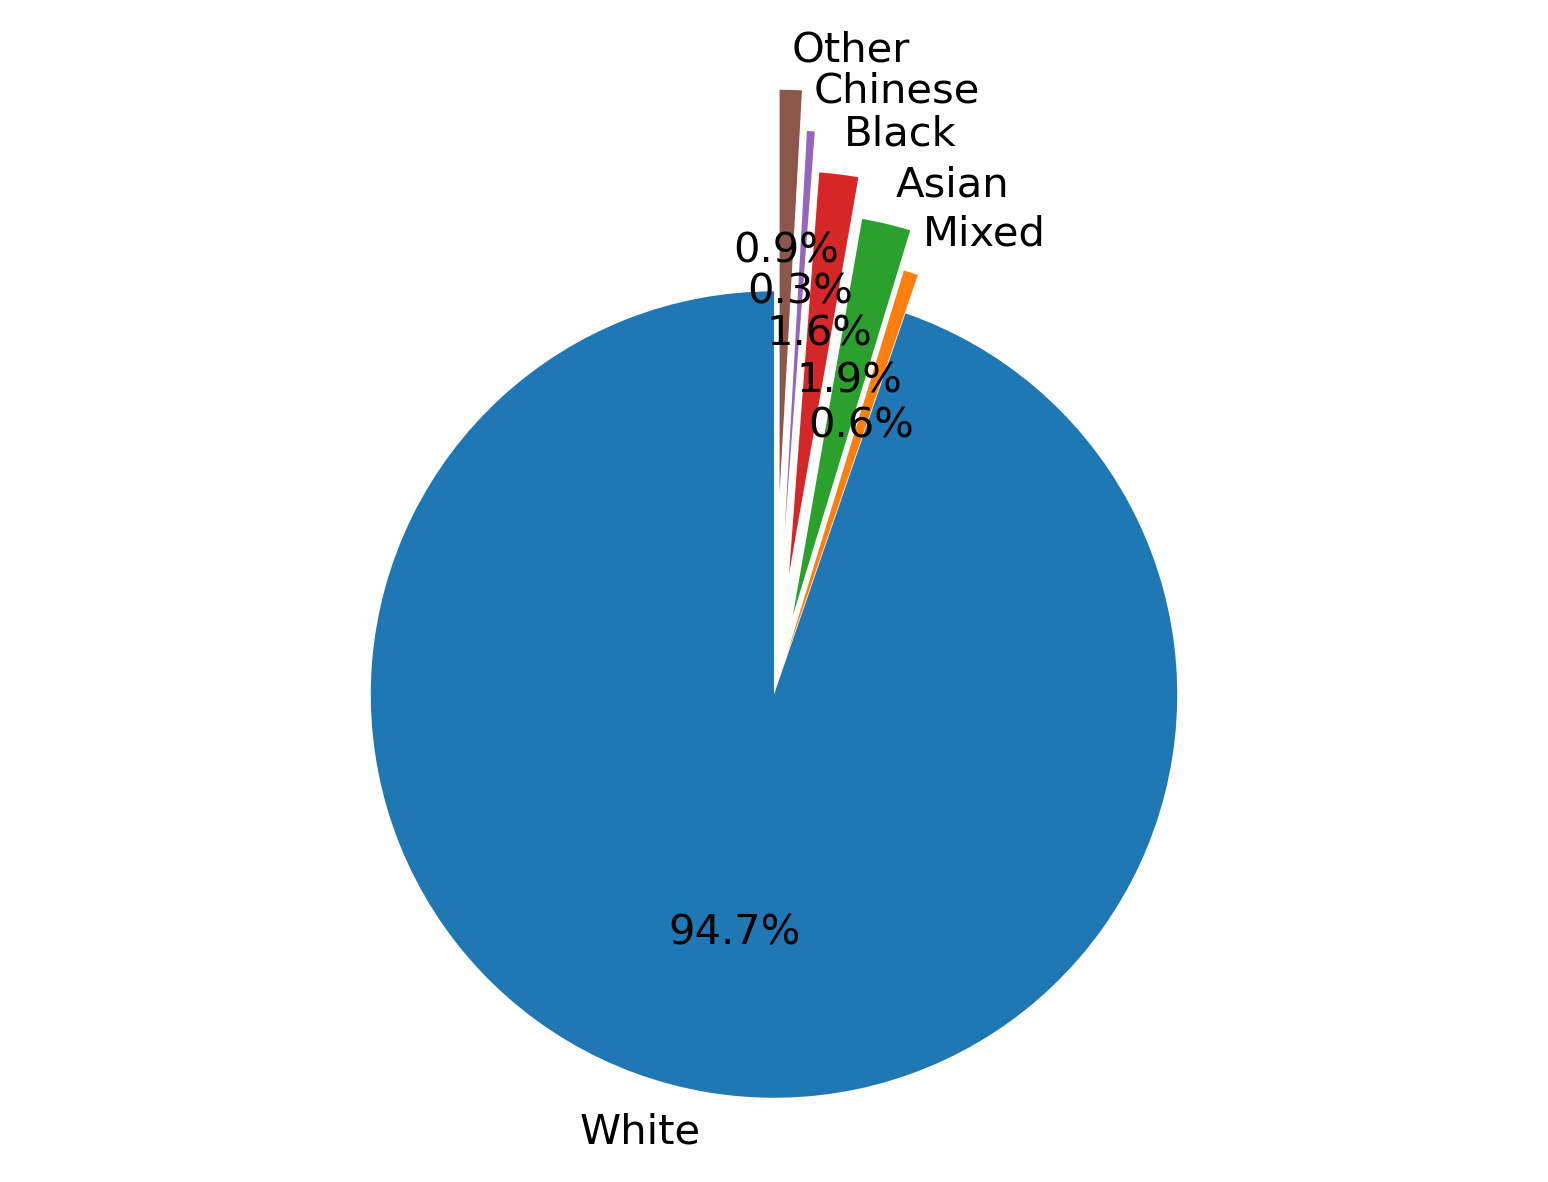

In [22]:
labels= list(Dict_ethnicity.keys())
sizes=[]
for x in labels:
    sizes.append(len(ukb200K_ch_cancer[ukb200K_ch_cancer['ethnicity_simple']==Dict_ethnicity[x]]))
explode = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plt.pie(sizes,labels=labels, startangle=90, autopct='%1.1f%%', explode=explode)
plt.axis('equal')
plt.show()

### Select non-HN mutations

In [23]:
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]['patient'].tolist()
boostDM_predictions_nonHN = boostDM_predictions[boostDM_predictions['patient'].isin(non_HN_patients)].reset_index(drop=True)
len(boostDM_predictions_nonHN)

201857

In [24]:
ethnicity_simple = []
for x in tqdm(boostDM_predictions_nonHN['patient']):
    ethnicity_simple.append(list(set(ukb200K_ch_cancer[ukb200K_ch_cancer['patient']==x]['ethnicity_simple']))[0])
boostDM_predictions_nonHN['Ethnicity']=ethnicity_simple
len(boostDM_predictions_nonHN)

100%|█████████████████████████████████| 201857/201857 [01:02<00:00, 3232.49it/s]


201857

## 2- Series Description

In [25]:
genes12 = ['DNMT3A', 'TET2', 'ASXL1', 'CHEK2', 'TP53', 'PPM1D', 'SF3B1', 'SRSF2','U2AF1', 'GNAS','IDH2', 'MDM4']

In [26]:
### Describing Series
for x in list(Dict_ethnicity.keys()):
    print(f"Number of {x} cases: {len(ukb200K_ch_cancer[ukb200K_ch_cancer['ethnicity_simple']==Dict_ethnicity[x]])}")
    print(f"Number of {x} cases with CH driver mutations: {len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['Drivers_12genes']==1)&(boostDM_predictions_nonHN['Ethnicity']==Dict_ethnicity[x])]['patient']))/len(ukb200K_ch_cancer[ukb200K_ch_cancer['ethnicity_simple']==Dict_ethnicity[x]])*100}")


Number of White cases: 440384
Number of White cases with CH driver mutations: 8.204884827786659
Number of Mixed cases: 2698
Number of Mixed cases with CH driver mutations: 7.412898443291327
Number of Asian cases: 9065
Number of Asian cases with CH driver mutations: 7.942636514065085
Number of Black cases: 7246
Number of Black cases with CH driver mutations: 6.707148771736131
Number of Chinese cases: 1451
Number of Chinese cases with CH driver mutations: 6.753962784286699
Number of Other cases: 4112
Number of Other cases with CH driver mutations: 7.368677042801557


### Mutational landscape by case

In [27]:
# Mutational landscape by ethnicity group
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]

Mut_case = []
for gene in boostDM_predictions_nonHN['SYMBOL'].unique():
    #Female
    
    freq_driv_1 = len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) &\
                                                (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                (boostDM_predictions_nonHN['Ethnicity']==1)]['patient']))
    freq_driv_2 = len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) &\
                                                (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                (boostDM_predictions_nonHN['Ethnicity']==2)]['patient']))
    freq_driv_3 = len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) &\
                                                (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                (boostDM_predictions_nonHN['Ethnicity']==3)]['patient']))
    freq_driv_4 = len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) &\
                                                (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                (boostDM_predictions_nonHN['Ethnicity']==4)]['patient']))
    freq_driv_5 = len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) &\
                                                (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                (boostDM_predictions_nonHN['Ethnicity']==5)]['patient']))
    freq_driv_6 = len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) &\
                                                (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                (boostDM_predictions_nonHN['Ethnicity']==6)]['patient']))

   
    #     freq = len(maf_can_PASS_VAF_nonrep.groupby(['SYMBOL'])['case'].unique()[gene])
    Mut_case.append([gene, freq_driv_1, freq_driv_2, freq_driv_3, freq_driv_4, freq_driv_5, freq_driv_6])
Mut_case

[['SRSF2', 549, 2, 8, 2, 0, 2],
 ['TET2', 8929, 50, 244, 129, 25, 78],
 ['DNMT3A', 19749, 111, 314, 266, 58, 161],
 ['ASXL1', 2360, 7, 30, 16, 5, 11],
 ['SF3B1', 665, 5, 7, 11, 1, 3],
 ['TP53', 2029, 13, 32, 41, 1, 18],
 ['PPM1D', 840, 2, 10, 9, 3, 3],
 ['CHEK2', 2038, 15, 94, 16, 7, 27],
 ['MDM4', 105, 2, 0, 3, 2, 2],
 ['IDH2', 122, 0, 2, 3, 0, 3],
 ['GNAS', 239, 1, 5, 2, 0, 4],
 ['U2AF1', 437, 0, 6, 6, 2, 5]]

In [28]:
Mut_case = pd.DataFrame(Mut_case, columns = ['Gene']+list(Dict_ethnicity.keys())).sort_values('White', ascending=False)
Mut_case.reset_index(drop=True)

,Gene,White,Mixed,Asian,Black,Chinese,Other
0,DNMT3A,19749,111,314,266,58,161
1,TET2,8929,50,244,129,25,78
2,ASXL1,2360,7,30,16,5,11
3,CHEK2,2038,15,94,16,7,27
4,TP53,2029,13,32,41,1,18
5,PPM1D,840,2,10,9,3,3
6,SF3B1,665,5,7,11,1,3
7,SRSF2,549,2,8,2,0,2
8,U2AF1,437,0,6,6,2,5
9,GNAS,239,1,5,2,0,4


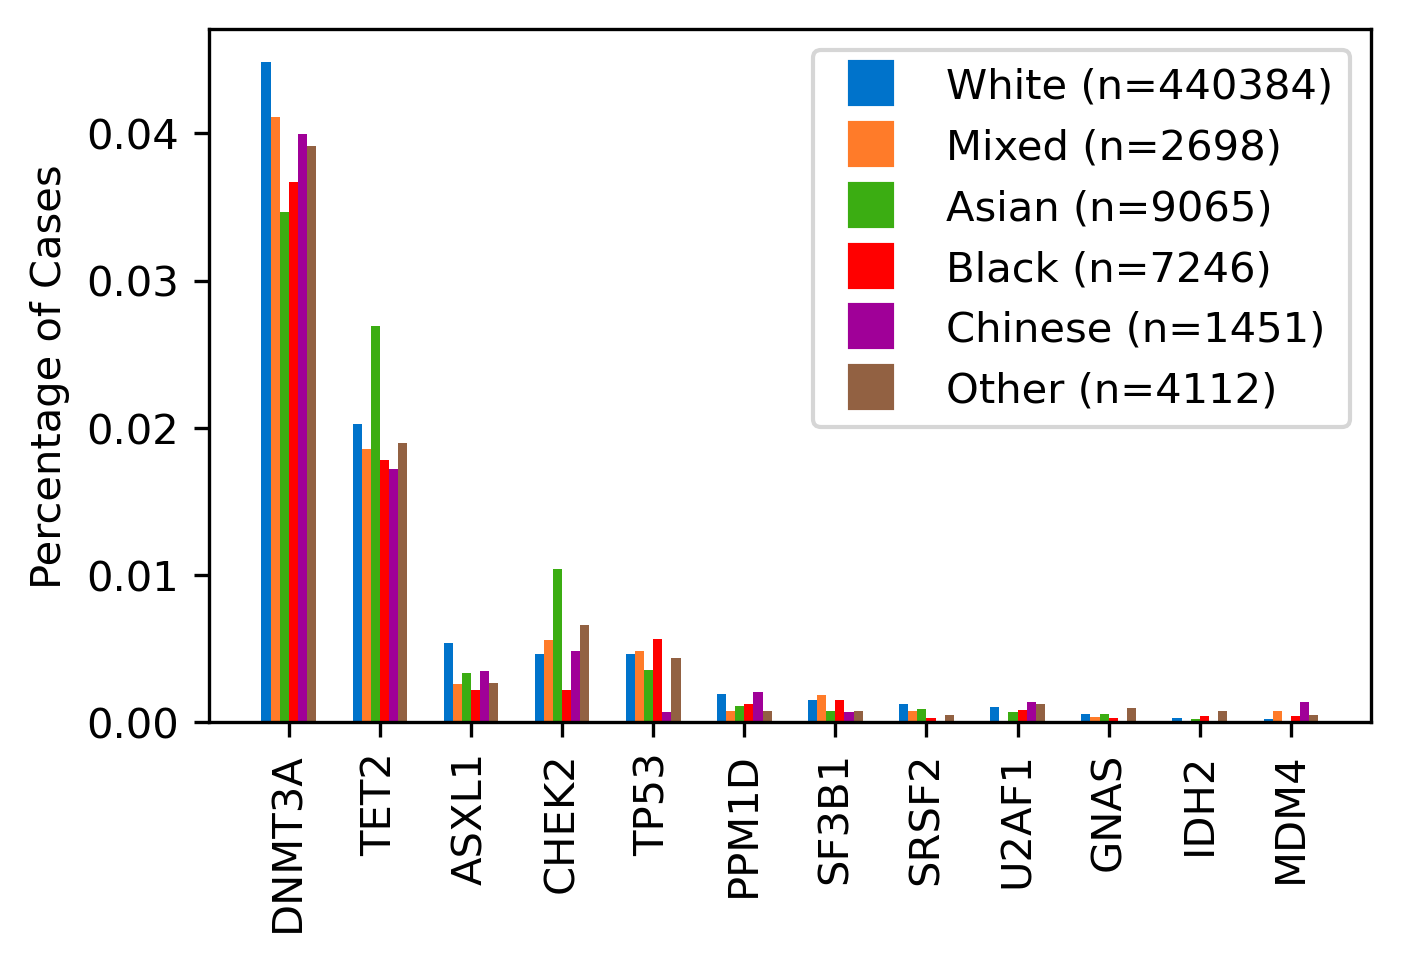

In [29]:
import numpy as np  
import matplotlib.pyplot as plt  

X = Mut_case.Gene
White = Mut_case.White/len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==1)])
Mixed = Mut_case.Mixed/len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==2)])
Asian = Mut_case.Asian/len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==3)])
Black = Mut_case.Black/len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==4)])
Chinese = Mut_case.Chinese/len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==5)])
Other = Mut_case.Other/len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==6)])
X_axis = np.arange(len(X)) 

plt.figure(figsize=(5, 3))
plt.bar(X_axis - 0.25, White, 0.1, label = 'White', color ='#0073cb') 
plt.bar(X_axis - 0.15, Mixed, 0.1, label = 'Mixed', color ='#ff7b29') 
plt.bar(X_axis - 0.05, Asian, 0.1, label = 'Asian', color ='#3bad12') 
plt.bar(X_axis + 0.05, Black, 0.1, label = 'Black', color='red') 
plt.bar(X_axis + 0.15, Chinese, 0.1, label = 'Chinese', color='#a00098') 
plt.bar(X_axis + 0.25, Other, 0.1, label = 'Other', color='#926142') 

# Custom legend
custom_legend_labels = [f"White (n={len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==1)])})",
                        f"Mixed (n={len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==2)])})",
                        f"Asian (n={len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==3)])})",
                        f"Black (n={len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==4)])})",
                        f"Chinese (n={len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==5)])})",
                        f"Other (n={len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==6)])})"]
                    
custom_legend_handles = [plt.Line2D([0], [0], color=color, marker='s', linestyle='', markersize=10) for color in ['#0073cb', '#ff7b29', '#3bad12', 'red', '#a00098', '#926142']]

plt.legend(custom_legend_handles, custom_legend_labels, loc='upper right')
  
plt.xticks(X_axis, X, rotation=90) 
plt.ylabel("Percentage of Cases")  
plt.show() 

In [30]:
# Mutational landscape by ethnicity group
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]

Mut_case = []
for gene in boostDM_predictions_nonHN['SYMBOL'].unique():
    #Female
    
    freq_driv_1 = len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) &\
                                                (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                (boostDM_predictions_nonHN['Ethnicity']==1)]['patient']))
    freq_driv_2 = len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) &\
                                                (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                (boostDM_predictions_nonHN['Ethnicity']==2)]['patient']))
    freq_driv_3 = len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) &\
                                                (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                (boostDM_predictions_nonHN['Ethnicity']==3)]['patient']))
    freq_driv_4 = len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) &\
                                                (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                (boostDM_predictions_nonHN['Ethnicity']==4)]['patient']))
    freq_driv_5 = len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) &\
                                                (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                (boostDM_predictions_nonHN['Ethnicity']==5)]['patient']))
    freq_driv_6 = len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) &\
                                                (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                (boostDM_predictions_nonHN['Ethnicity']==6)]['patient']))

   
    #     freq = len(maf_can_PASS_VAF_nonrep.groupby(['SYMBOL'])['case'].unique()[gene])
    Mut_case.append([gene,\
                     freq_driv_1/len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==1)]),\
                     freq_driv_2/len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==2)]),\
                     freq_driv_3/len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==3)]),\
                     freq_driv_4/len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==4)]),\
                     freq_driv_5/len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==5)]),\
                     freq_driv_6/len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==6)])])

Mut_case = pd.DataFrame(Mut_case, columns = ['Gene']+list(Dict_ethnicity.keys())).sort_values('White', ascending=False)
Mut_case = Mut_case.reset_index(drop=True)
Mut_case

,Gene,White,Mixed,Asian,Black,Chinese,Other
0,DNMT3A,0.044845,0.041142,0.034639,0.036710,0.039972,0.039154
1,TET2,0.020275,0.018532,0.026917,0.017803,0.017229,0.018969
2,ASXL1,0.005359,0.002595,0.003309,0.002208,0.003446,0.002675
3,CHEK2,0.004628,0.005560,0.010370,0.002208,0.004824,0.006566
4,TP53,0.004607,0.004818,0.003530,0.005658,0.000689,0.004377
5,PPM1D,0.001907,0.000741,0.001103,0.001242,0.002068,0.000730
6,SF3B1,0.001510,0.001853,0.000772,0.001518,0.000689,0.000730
7,SRSF2,0.001247,0.000741,0.000883,0.000276,0.000000,0.000486
8,U2AF1,0.000992,0.000000,0.000662,0.000828,0.001378,0.001216
9,GNAS,0.000543,0.000371,0.000552,0.000276,0.000000,0.000973


In [31]:
### Describing Series
CH_freq = []
for x in list(Dict_ethnicity.keys()):
    CH_freq.append(len(set(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['Drivers_12genes']==1)&(boostDM_predictions_nonHN['Ethnicity']==Dict_ethnicity[x])]['patient']))/len(ukb200K_ch_cancer[ukb200K_ch_cancer['ethnicity_simple']==Dict_ethnicity[x]]))
Mut_case.loc[len(Mut_case.index)] =  ['CH']+CH_freq  
Mut_case

,Gene,White,Mixed,Asian,Black,Chinese,Other
0,DNMT3A,0.044845,0.041142,0.034639,0.036710,0.039972,0.039154
1,TET2,0.020275,0.018532,0.026917,0.017803,0.017229,0.018969
2,ASXL1,0.005359,0.002595,0.003309,0.002208,0.003446,0.002675
3,CHEK2,0.004628,0.005560,0.010370,0.002208,0.004824,0.006566
4,TP53,0.004607,0.004818,0.003530,0.005658,0.000689,0.004377
5,PPM1D,0.001907,0.000741,0.001103,0.001242,0.002068,0.000730
6,SF3B1,0.001510,0.001853,0.000772,0.001518,0.000689,0.000730
7,SRSF2,0.001247,0.000741,0.000883,0.000276,0.000000,0.000486
8,U2AF1,0.000992,0.000000,0.000662,0.000828,0.001378,0.001216
9,GNAS,0.000543,0.000371,0.000552,0.000276,0.000000,0.000973


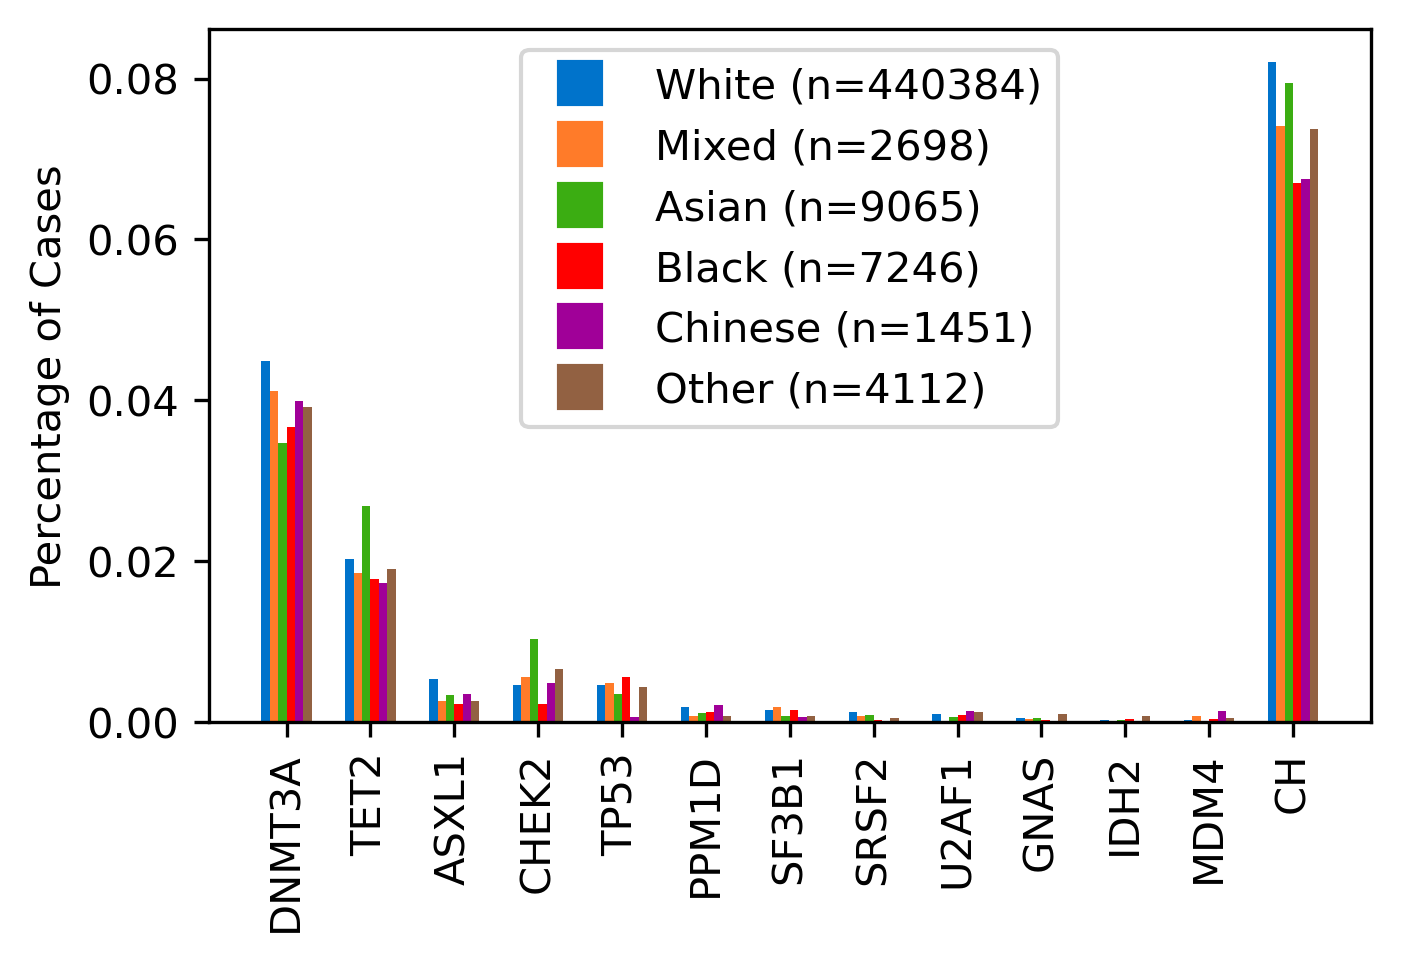

In [32]:
import numpy as np  
import matplotlib.pyplot as plt  

X = Mut_case.Gene
White = Mut_case.White
Mixed = Mut_case.Mixed
Asian = Mut_case.Asian
Black = Mut_case.Black
Chinese = Mut_case.Chinese
Other = Mut_case.Other
X_axis = np.arange(len(X)) 

plt.figure(figsize=(5, 3))
plt.bar(X_axis - 0.25, White, 0.1, label = 'White', color ='#0073cb') 
plt.bar(X_axis - 0.15, Mixed, 0.1, label = 'Mixed', color ='#ff7b29') 
plt.bar(X_axis - 0.05, Asian, 0.1, label = 'Asian', color ='#3bad12') 
plt.bar(X_axis + 0.05, Black, 0.1, label = 'Black', color='red') 
plt.bar(X_axis + 0.15, Chinese, 0.1, label = 'Chinese', color='#a00098') 
plt.bar(X_axis + 0.25, Other, 0.1, label = 'Other', color='#926142') 

# Custom legend
custom_legend_labels = [f"White (n={len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==1)])})",
                        f"Mixed (n={len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==2)])})",
                        f"Asian (n={len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==3)])})",
                        f"Black (n={len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==4)])})",
                        f"Chinese (n={len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==5)])})",
                        f"Other (n={len(ukb200K_ch_cancer[(ukb200K_ch_cancer['ethnicity_simple']==6)])})"]
                    
custom_legend_handles = [plt.Line2D([0], [0], color=color, marker='s', linestyle='', markersize=10) for color in ['#0073cb', '#ff7b29', '#3bad12', 'red', '#a00098', '#926142']]

plt.legend(custom_legend_handles, custom_legend_labels, loc='upper center')
  
plt.xticks(X_axis, X, rotation=90) 
plt.ylabel("Percentage of Cases")  
# plt.legend() 
plt.show() 

# 3- Age associations

### Age all togather

In [37]:
#Remove cases with prior hemathological cancer
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
ukb200K_ch_cancer_logistic.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)
len(ukb200K_ch_cancer_logistic)

467202

In [38]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc
    
CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_nonDriver']==0]

name = []
OR = []
cilow = []
ciup = []
pval = []
sig = []
    
#run model
for i, gene in enumerate(['White', 'Mixed',  'Asian',  'Black', 'Chinese', 'Other']):
    CH_driver_ethnicity = CH_driver_matrix[CH_driver_matrix['ethnicity_simple']==i+1]
    model_hematopost = smf.logit(formula= 'CH_driver ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_ethnicity).fit()
    name.append(gene)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['significant' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.265096
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.250826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.261032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.224962
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.235537
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.236201
         Iterations 7


,gene,OR,Lower CI,Upper CI,pval,sig,q_value
0,White,1.046813,1.044971,1.048658,0.000000e+00,significant,0.000000e+00
1,Mixed,1.036858,1.014911,1.059280,9.136080e-04,significant,1.096330e-03
2,Asian,1.035609,1.024158,1.047187,6.916377e-10,significant,2.074913e-09
3,Black,1.044956,1.029063,1.061094,1.870380e-08,significant,3.740759e-08
4,Chinese,1.054516,1.019930,1.090275,1.809636e-03,significant,1.809636e-03
5,Other,1.053670,1.033933,1.073783,5.996700e-08,significant,8.995050e-08


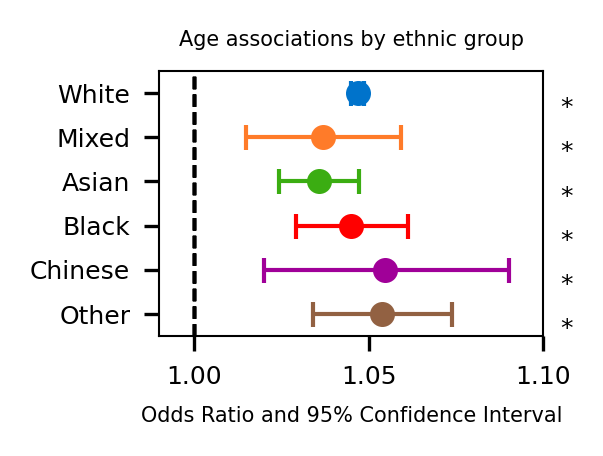

In [39]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(2.1, 1.5), dpi=300)

xlimit = 1.10
ylimit = len(varlist)-1
Color_dic = {'White':'#0073cb',
             'Mixed':'#ff7b29',
             'Asian':'#3bad12',
             'Black':'red',
             'Chinese':'#a00098',
             'Other':'#926142'} 

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    plt.errorbar(x=[row['OR']], y=row['gene'], xerr=ci,
             ecolor=Color_dic[row['gene']], capsize=3, linestyle='None', linewidth=1, marker="o", 
             markersize=5, mfc=Color_dic[row['gene']], mec=Color_dic[row['gene']])
   
    if row['sig'] == 'significant':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.005, ylimit-idx-0.5, '*', style='italic', fontsize=6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.005, ylimit-idx-0.5, 'ns', style='italic', fontsize=6)

        plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=5)
ax.set_title('Age associations by ethnic group', fontdict={'size':5})
plt.tight_layout()
plt.xlim([0.99, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.yticks(fontsize=6)
plt.xticks([1, 1.05, 1.1], fontsize=6)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()